In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from collections import defaultdict

# Settings
DATASET_DIR = "New_Dataset"
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms (same as validation)
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(f"{DATASET_DIR}/test", transform=val_transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_data.classes

# Load model
model = models.efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_features, len(class_names))
)
model.load_state_dict(torch.load("best_soyabean_model.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# Metrics
true_positives = defaultdict(int)
false_positives = defaultdict(int)
true_negatives = defaultdict(int)
false_negatives = defaultdict(int)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate per-class metrics
for i in range(len(all_labels)):
    true = all_labels[i]
    pred = all_preds[i]
    for cls in range(len(class_names)):
        if pred == cls and true == cls:
            true_positives[cls] += 1
        elif pred == cls and true != cls:
            false_positives[cls] += 1
        elif pred != cls and true == cls:
            false_negatives[cls] += 1
        elif pred != cls and true != cls:
            true_negatives[cls] += 1

print("Class-wise metrics:")
for cls in range(len(class_names)):
    print(f"Class: {class_names[cls]}")
    print(f"  True Positives: {true_positives[cls]}")
    print(f"  False Positives: {false_positives[cls]}")
    print(f"  False Negatives: {false_negatives[cls]}")
    print(f"  True Negatives: {true_negatives[cls]}")
    print()

# Optionally, print overall accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Overall Accuracy: {accuracy:.4f}")


Class-wise metrics:
Class: Healthy_Soyabean
  True Positives: 86
  False Positives: 0
  False Negatives: 0
  True Negatives: 258

Class: Soyabean_Mosaic
  True Positives: 61
  False Positives: 14
  False Negatives: 25
  True Negatives: 244

Class: Soyabean_Rust
  True Positives: 47
  False Positives: 29
  False Negatives: 39
  True Negatives: 229

Class: Soyabean_Spectoria_Brown_Spot
  True Positives: 68
  False Positives: 39
  False Negatives: 18
  True Negatives: 219

Overall Accuracy: 0.7616


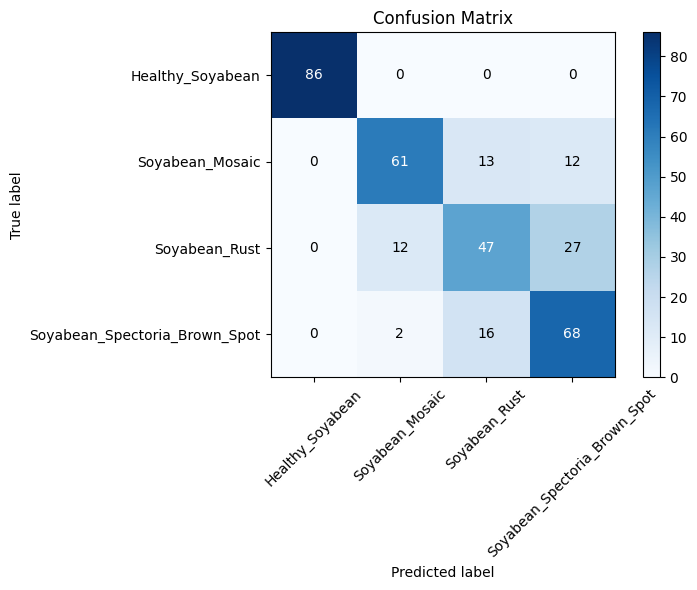

In [2]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
